In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
def calculate_logistic_regression_prob(row, params):
    linear_combination = 0
    for feature in params.columns.drop(['Player','if_server']):
        if feature in row.index:  # 检查该特征列是否存在于行中
            linear_combination += row[feature] * params[feature].values[0]
    
    #prob = 1 / (1 + np.exp(-linear_combination))
    return linear_combination

In [229]:
MATCH = "2023-wimbledon-1701"
SET = 5
df = pd.read_csv("Wimbledon_featured_matches.csv")
df = df.loc[df["match_id"] == MATCH]

P1 = df["player1"].values[0]
P2 = df["player2"].values[0]
params = pd.read_csv("all_players.csv")
P1_params = params[params["Player"] == P1]
P2_params = params[params["Player"] == P2]

P1_df = pd.read_csv(f"{P1}.csv")
P1_df = P1_df[P1_df["match_id"] == MATCH]
P2_df = pd.read_csv(f"{P2}.csv")
P2_df = P2_df[P2_df["match_id"] == MATCH]

In [230]:
P1_df.columns

Index(['player', 'match_id', 'set_no', 'game_no', 'point_no', 'elapsed_time',
       'p1_score', 'p2_score', 'y', 'if_score', 'if_nscore', 'if_server',
       'if_win_game', 'if_win_set', 'if_end_game', 'if_end_set', 'game_point',
       'break_point', 'break_fail', 'broken', 'rally_count', 'speed_mph',
       'net_pt', 'serve_width', 'serve_depth', 'return_depth',
       'weighted_sum_if_score', 'weighted_sum_if_nscore',
       'weighted_sum_if_win_game', 'weighted_sum_if_win_set',
       'weighted_sum_game_point', 'weighted_sum_break_point',
       'weighted_sum_break_fail', 'weighted_sum_broken',
       'weighted_sum_rally_count', 'score', 'quality'],
      dtype='object')

In [231]:
mom = pd.DataFrame()

mom[P1] = P1_df.set_index('point_no').apply(lambda row: pd.Series({'mom':calculate_logistic_regression_prob(row, P1_params)}), axis=1)
mom[P2] = P2_df.set_index('point_no').apply(lambda row: pd.Series({'mom':calculate_logistic_regression_prob(row, P2_params)}), axis=1)

In [232]:
print(mom)
mom.to_csv("mom.csv")

          Carlos Alcaraz  Novak Djokovic
point_no                                
1               0.000000        0.000000
2              -0.002279        0.030440
3              -0.176044        0.004458
4              -0.258369       -0.003152
5              -0.131464        0.028864
...                  ...             ...
330            -0.037906        0.518920
331            -0.209811        0.229865
332            -0.282089        0.101481
333            -0.267394        2.088378
334            -0.243148        0.033864

[334 rows x 2 columns]


In [233]:
df = df.merge(mom, on='point_no', how='left')
df = df.loc[df["set_no"] == SET]
df.head(5)


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Carlos Alcaraz,Novak Djokovic
273,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,03:57:11,5,1,274,2,2,0,...,0,24.728,15.650,5,97.0,W,CTL,D,-0.084703,-3.046664
274,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,03:57:58,5,1,275,2,2,0,...,0,28.056,22.534,7,95.0,B,NCTL,ND,-0.053747,-1.503654
275,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,03:59:07,5,1,276,2,2,0,...,0,7.730,4.640,2,109.0,BW,NCTL,ND,-0.042827,-0.737530
276,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,03:59:51,5,1,277,2,2,0,...,0,18.626,17.664,6,92.0,B,NCTL,ND,-0.191760,-0.374146
277,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:00:47,5,1,278,2,2,0,...,0,12.669,12.304,4,123.0,C,NCTL,ND,-0.275343,-0.203215


yeah


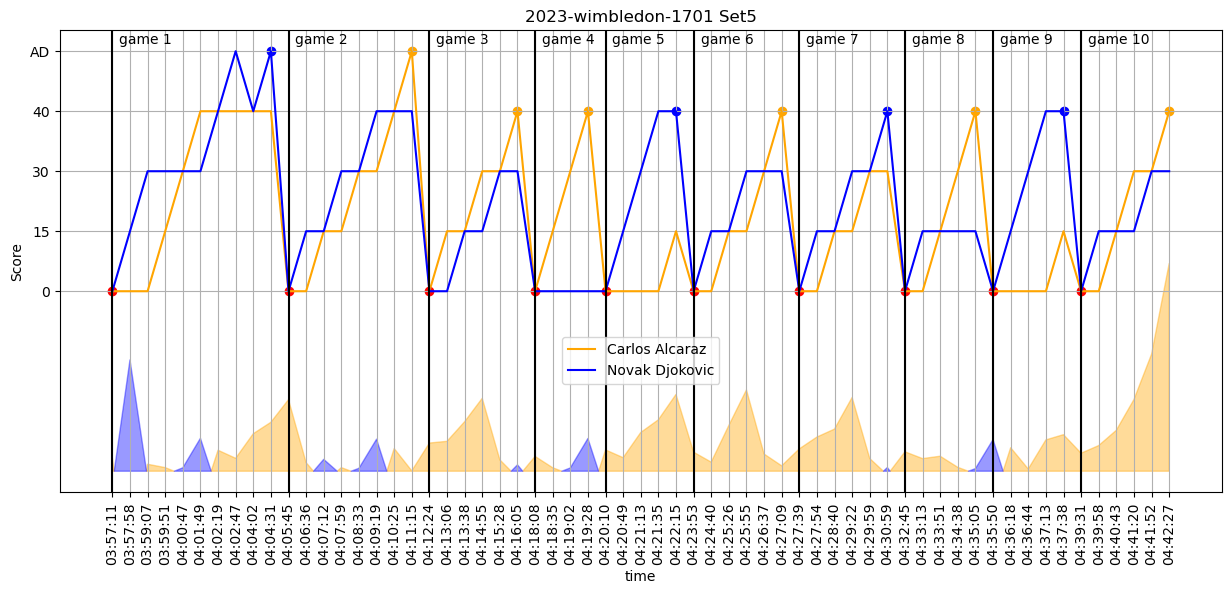

In [258]:

location = 3
# df[["p1_points_won","p2_points_won"]]

plt.figure(figsize=(15, 6))

# 绘制比分曲线
sns.lineplot(x = df["elapsed_time"], y = df["p1_score"], color = "orange", label=P1)
sns.lineplot(x = df["elapsed_time"], y = df["p2_score"], color = "blue", label=P2)
#sns.lineplot(x = df["elapsed_time"], y = df[P1]-location, color = "orange")
#sns.lineplot(x = df["elapsed_time"], y = df[P2]-location, color = "blue")
#sns.lineplot(x = df["elapsed_time"], y = df["p1_score"]-df["p2_score"])
# 添加标签和标题
plt.xlabel('time')
plt.ylabel('Score')
plt.title(MATCH + " Set" + str(SET))

# 添加网格
plt.grid()

# 添加比分标记
game = 1

for i, (p1, p2) in enumerate(zip(df["p1_score"], df["p2_score"])):
    if p1 == "0" and p2 == "0" :
    # beginning of a new game
        plt.axvline(x = i, color = "black", alpha = 1)
        plt.scatter(x = i, y = 0, color = "red", marker="o")
        plt.annotate("game " +  str(game), (i, "AD"),textcoords= "offset points",
                     xytext=(5, 5), ha = "left")
        game += 1

        if i>= 1 and df["p1_score"].iloc[i-1] < df["p2_score"].iloc[i-1]:
            plt.scatter(x = i-1, y = df["p2_score"].iloc[i-1], color = "blue", marker = "o")
        elif i>=1  and df["p1_score"].iloc[i-1] > df["p2_score"].iloc[i-1]:
            plt.scatter(x = i-1, y = df["p1_score"].iloc[i-1], color = "orange", marker = "o")
    if game == 11 and df["p1_score"].iloc[i] == "0" and df["p2_score"].iloc[i] == "0":
        print("yeah")
        plt.scatter(x = i+5, y = "40", color = "orange", marker = "o")
    


# 添加游戏和盘比分标记
# for i, (game, set) in enumerate(zip(games, sets)):
#     plt.annotate(f'Game {game}\nSet {set}', (i, 0), textcoords="offset points", xytext=(0, -20), ha='center')

# 添加图例
ax = plt.gca()

# 平移控制
h = 0.5

# 翻转y轴
ax.invert_yaxis()
#plt.fill_between(df["elapsed_time"], df[P1]-location, df[P2]-location, where=(df[P1] >= df[P2]), interpolate=True, color='orange', alpha=0.5)
#plt.fill_between(df["elapsed_time"],  df[P1]-location, df[P2]-location, where=(df[P1] < df[P2]), interpolate=True, color='blue', alpha=0.5)
plt.fill_between(df["elapsed_time"].values[::-1], df[P1]-df[P2]+h-location, -location, where=(df[P1] >= df[P2]-h), interpolate=True, color='orange', alpha=0.4)
plt.fill_between(df["elapsed_time"].values[::-1],  df[P2]-h-df[P1]-location, -location, where=(df[P1] < df[P2]-h), interpolate=True, color='blue', alpha=0.4)

plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.35))
# 显示图表
plt.show()